# Install pytorch lightning

In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 796 kB 10.2 MB/s 
     |████████████████████████████████| 136 kB 49.4 MB/s 
     |████████████████████████████████| 529 kB 50.0 MB/s 
     |████████████████████████████████| 87 kB 2.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=1e0fe8cfabc2180c42e93a25a8f172012ad16ff2a12a648e812a9a491fa05fe8
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


# Import libraries we are going to use

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from nltk.tokenize import wordpunct_tokenize
from torchmetrics import BLEUScore
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import random

# Download English-Spanish dataset

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

--2022-11-04 13:27:20--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.02s   

2022-11-04 13:27:20 (138 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
!unzip spa-eng.zip

Archive:  spa-eng.zip
   creating: spa-eng/
  inflating: spa-eng/_about.txt      
  inflating: spa-eng/spa.txt         


In [ ]:
!ls ./spa-eng/

_about.txt  spa.txt


In [ ]:
!head ./spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


# Prepare dataset for Neural Machine Translation

In [ ]:
class CorpusDataset(Dataset):
  
  PAD_TOKEN = "<PAD>" # 0
  START_TOKEN = "<START>" # 1
  END_TOKEN = "<END>" # 2
  UNK_TOKEN = "<UNK>" # 3
    
  def __init__(self, src_sentences, dst_sentences, src_token2id=None, src_id2token=None, dst_token2id=None, dst_id2token=None,
               frequency_threshold=5):
    
    self.src_sentences = self._preprocess_sentences(src_sentences)
    self.dst_sentences = self._preprocess_sentences(dst_sentences)
    assert len(self.src_sentences) == len(self.dst_sentences)
    
    if src_token2id is None and src_id2token is None and dst_token2id is None and dst_id2token is None:
      self.src_token2id, self.src_id2token = self._build_token2id(self.src_sentences, frequency_threshold)
      self.dst_token2id, self.dst_id2token = self._build_token2id(self.dst_sentences, frequency_threshold)
    else:
      self.src_token2id, self.src_id2token = src_token2id, src_id2token
      self.dst_token2id, self.dst_id2token = dst_token2id, dst_id2token
    
  def _preprocess_sentences(self, sentences):
    sentences = [wordpunct_tokenize(s.lower()) for s in sentences]
    return sentences
    
  def _build_token2id(self, sentences, frequency_threshold):
      
    token2count = dict()
    for sentence in sentences:
      for token in sentence:
        token2count[token] = token2count.get(token, 0) + 1
    pairs = list(token2count.items())
    pairs.sort(key=lambda p:p[1], reverse=True)
    id2token = [self.PAD_TOKEN, self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN]
    id2token.extend(p[0] for p in pairs if p[1] >= frequency_threshold) # keep only tokens with a frequency >= frequency_threshold
    token2id = { token:_id for _id, token in enumerate(id2token) }

    return token2id, id2token

  def _tokens2ids(self, token2id, tokens, is_target=False):
    ids = []
    if is_target:
      ids.append(token2id[self.START_TOKEN])
    for token in tokens:
      if token in token2id:
        ids.append(token2id[token])
      else:
        ids.append(token2id[self.UNK_TOKEN])
    if is_target:
      ids.append(token2id[self.END_TOKEN])
    return ids
    
  def __getitem__(self, idx):
    src_tokens, dst_tokens = self.src_sentences[idx], self.dst_sentences[idx]
    src_ids, dst_ids = self._tokens2ids(self.src_token2id, src_tokens), self._tokens2ids(self.dst_token2id, dst_tokens, is_target=True)
    return {
        "idx": idx,
        "src": src_ids,
        "dst": dst_ids
    }
    
  def __len__(self):
    return len(self.src_sentences)
    
  def src_ids2string(self, ids):
    tokens = []
    for id in ids:
      if id == 2: # END_TOKEN
        break
      if id >= 3:
        tokens.append(self.src_id2token[id])
    return " ".join(tokens)

  def dst_ids2string(self, ids):
    tokens = []
    for id in ids:
      if id == 2: # END_TOKEN
        break
      if id >= 3:
        tokens.append(self.dst_id2token[id])
    return " ".join(tokens)

In [ ]:
# Read spa.txt and collect english and spanish sentences
english_sentences = []
spanish_sentences = []
with open('./spa-eng/spa.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    a, b = line.split('\t')
    english_sentences.append(a.strip())
    spanish_sentences.append(b.strip())

In [ ]:
len(english_sentences), len(spanish_sentences)

(118964, 118964)

In [ ]:
corpus_dataset = CorpusDataset(src_sentences=english_sentences, dst_sentences=spanish_sentences, frequency_threshold=2)

In [ ]:
print(f'Src vocab size: {len(corpus_dataset.src_id2token)}')
print(f'Dst vocab size: {len(corpus_dataset.dst_id2token)}')

Src vocab size: 8869
Dst vocab size: 15295


Split dataset into train, validation and test

In [ ]:
train_size = int(len(corpus_dataset) * 0.95)
val_size = int(len(corpus_dataset) * 0.025)
test_size = len(corpus_dataset) - train_size - val_size

print(f'Train size: {train_size}')
print(f'Val size: {val_size}')
print(f'Test size: {test_size}')

Train size: 113015
Val size: 2974
Test size: 2975


In [ ]:
train_dataset, val_dataset, test_dataset = random_split(corpus_dataset, [train_size, val_size, test_size])

# Code for BiLSTM+LSTM+Attention-based Neural Machine Translation

![picture](https://drive.google.com/uc?id=1dVORVYBJyAHJxnjO2L6v9DVKF7wvjpnI)

Source: *NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE* (https://arxiv.org/pdf/1409.0473.pdf)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
class BiLSTM_EncoderModule(nn.Module):
    def __init__(self, vocab_size, embeddings_size, hidden_size):
      super().__init__()

      self.embeddings_table = nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=embeddings_size,
        padding_idx=0,
      )
      self.embeddings_size = embeddings_size
      self.hidden_size = hidden_size
      
      self.lstm = nn.LSTM(
          input_size=embeddings_size,
          hidden_size=hidden_size,
          num_layers=1,
          batch_first=True,
          bidirectional=True,
      )
        
    def forward(self, src_sentences, src_lengths):
      embedded_sentences = self.embeddings_table(src_sentences)
      packed_sentences = pack_padded_sequence(embedded_sentences,
                                              src_lengths.cpu(),
                                              batch_first=True)
      
      batch_size, max_src_sentence_length = src_sentences.shape
      
      # assert max_src_sentence_length == src_lengths.max()
      
      h0 = self.init_hidden_state(batch_size)
      c0 = self.init_cell_state(batch_size)
      output, (hidden_states, cell_states) = self.lstm(packed_sentences, (h0, c0))
      all_hidden_states, _ = pad_packed_sequence(output,
                                                  batch_first=True,
                                                  padding_value=0,
                                                  total_length=max_src_sentence_length)

      # assert all_hidden_states.shape == (batch_size, max_src_sentence_length, 2 * self.hidden_size)
      # assert hidden_states.shape == (2, batch_size, self.hidden_size)
      # assert cell_states.shape == (2, batch_size, self.hidden_size)
      
      return all_hidden_states, hidden_states, cell_states
    
    def init_hidden_state(self, batch_size):
      return torch.zeros(2, batch_size, self.hidden_size).to(DEVICE)
    
    def init_cell_state(self, batch_size):
      return torch.zeros(2, batch_size, self.hidden_size).to(DEVICE)

class LSTM_DecoderModule(nn.Module):
    def __init__(
            self,
            embeddings_size,
            hidden_size,
            start_idx,
            dropout_prob,
            dst_vocab_size
        ):
        super().__init__()
        
        self.embeddings_table = nn.Embedding(
          num_embeddings=dst_vocab_size,
          embedding_dim=embeddings_size,
          padding_idx=0,
        )
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        self.start_idx = torch.tensor(start_idx).to(DEVICE)
        self.dst_vocab_size = dst_vocab_size

        self.W_h = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.W_c = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.lstm_cell = nn.LSTMCell(input_size=embeddings_size+hidden_size,
                                     hidden_size=hidden_size,
                                     bias=True)
        self.W_attn = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.W_u = nn.Linear(3 * hidden_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(dropout_prob)
        self.W_vocab = nn.Linear(hidden_size, dst_vocab_size)        
        
    def teacher_forcing_decoding(
            self,
            all_enc_hidden_states,
            final_enc_hidden_states,
            final_enc_cell_states,
            dst_sentences,
            dst_lengths,            
        ):
        max_sentence_length = dst_lengths.max()
        batch_size = all_enc_hidden_states.shape[0]
        y = self.embeddings_table(self.start_idx).expand(batch_size, -1)
        o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        h = self.W_h(torch.cat((final_enc_hidden_states[0],
                                final_enc_hidden_states[1]),1))  # h0_dec
        c = self.W_c(torch.cat((final_enc_cell_states[0],
                                final_enc_cell_states[1]),1))  # c0_dec
        sentence_embeddings = self.embeddings_table(dst_sentences.permute(1,0))
        # assert sentence_embeddings.shape == (max_sentence_length, batch_size, self.embeddings_size)
        
        output = []
        
        for t in range(max_sentence_length):
            y_bar = torch.cat((y,o),1)
            # assert y_bar.shape == (batch_size, self.embeddings_size + self.hidden_size)
            # assert h.shape == (batch_size, self.hidden_size)
            # assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (self.W_attn(all_enc_hidden_states) * h.unsqueeze(1)).sum(-1)
            att = torch.softmax(e,-1)
            a = (all_enc_hidden_states * att.unsqueeze(2)).sum(1)
            # assert a.shape == (batch_size, 2 * self.hidden_size)
            u = torch.cat((a,h),1)
            # assert u.shape == (batch_size, 3 * self.hidden_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
            # assert o.shape == (batch_size, self.hidden_size)
            output.append(self.W_vocab(o))
            y = sentence_embeddings[t]
        
        output = torch.stack(output, 1)
        # assert output.shape == (batch_size, max_sentence_length, self.dst_vocab_size)
        return output
    
    def greedy_search_decoding(
            self,
            all_enc_hidden_states,
            final_enc_hidden_states,
            final_enc_cell_states,
            dst_lengths,
        ):
        
        max_sentence_length = dst_lengths.max()
        batch_size = all_enc_hidden_states.shape[0]
        y = self.embeddings_table(self.start_idx).expand(batch_size, -1)
        o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        h = self.W_h(torch.cat((final_enc_hidden_states[0],
                                final_enc_hidden_states[1]),1))  # h0_dec
        c = self.W_c(torch.cat((final_enc_cell_states[0],
                                final_enc_cell_states[1]),1))  # c0_dec        
        
        output = []
        
        for t in range(max_sentence_length):
            y_bar = torch.cat((y,o),1)
            # assert y_bar.shape == (batch_size, self.embeddings_size + self.hidden_size)
            # assert h.shape == (batch_size, self.hidden_size)
            # assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (self.W_attn(all_enc_hidden_states) * h.unsqueeze(1)).sum(-1)
            att = torch.softmax(e,-1)
            a = (all_enc_hidden_states * att.unsqueeze(2)).sum(1)
            # assert a.shape == (batch_size, 2 * self.hidden_size)
            u = torch.cat((a,h),1)
            # assert u.shape == (batch_size, 3 * self.hidden_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
            # assert o.shape == (batch_size, self.hidden_size)
            output.append(self.W_vocab(o))
            y = self.embeddings_table(torch.argmax(output[t], 1))
            # assert y.shape == (batch_size, self.embeddings_size)
        
        output = torch.stack(output, 1)
        # assert output.shape == (batch_size, max_sentence_length, self.dst_vocab_size)
        return output
    
class BiLSTM_LSTM_NeuralMachineTranslator(pl.LightningModule):

  def __init__(
    self,
    src_vocab_size,
    dst_vocab_size,
    start_idx,
    embeddings_size,
    hidden_size,
    dropout_prob,
    dst_ids2string,
  ):
    super().__init__()

    self.encoder_module = BiLSTM_EncoderModule(
      vocab_size=src_vocab_size,
      embeddings_size=embeddings_size,
      hidden_size=hidden_size)
    
    self.decoder_module = LSTM_DecoderModule(
      embeddings_size=embeddings_size,
      hidden_size=hidden_size,
      start_idx=start_idx,
      dropout_prob=dropout_prob,
      dst_vocab_size=dst_vocab_size)
    
    self.dst_ids2string = dst_ids2string
    
    self.train_gt_sentences = []
    self.train_gen_sentences = []
    self.val_gt_sentences = []
    self.val_gen_sentences = []
    self.test_gt_sentences = []
    self.test_gen_sentences = []
    self.test_idxs = []
        
  def teacher_forcing_decoding(
    self,
    src_sentences,
    src_lengths,
    dst_sentences,
    dst_lengths
  ):

    all_enc_hidden_states,\
    final_enc_hidden_states,\
    final_enc_cell_states = self.encoder_module(src_sentences, src_lengths)

    output = self.decoder_module.teacher_forcing_decoding(
        all_enc_hidden_states,
        final_enc_hidden_states,
        final_enc_cell_states,
        dst_sentences,
        dst_lengths)

    return output
    
  def greedy_search_decoding(
    self,
    src_sentences,
    src_lengths,
    dst_lengths,
  ):
      
    all_enc_hidden_states,\
    final_enc_hidden_states,\
    final_enc_cell_states = self.encoder_module(src_sentences, src_lengths)

    output = self.decoder_module.greedy_search_decoding(
        all_enc_hidden_states,
        final_enc_hidden_states,
        final_enc_cell_states,
        dst_lengths)

    return output

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    src_sentences = train_batch['src']
    src_lengths = train_batch['src_lengths']
    dst_sentences = train_batch['dst']
    dst_lengths = train_batch['dst_lengths']

    output = self.teacher_forcing_decoding(
        src_sentences,
        src_lengths,
        dst_sentences,
        dst_lengths)

    # accumulate sentences
    gen_sentences = output.argmax(-1)
    for i in range(gen_sentences.size(0)):
      self.train_gen_sentences.append(self.dst_ids2string(gen_sentences[i]))
      self.train_gt_sentences.append([self.dst_ids2string(dst_sentences[i])])

    # loss
    loss = F.cross_entropy(output.view(-1,output.shape[-1]),
                                     dst_sentences.view(-1))
    self.log('train_loss', loss, on_step=False, on_epoch=True)

    return loss

  def validation_step(self, val_batch, batch_idx):
    src_sentences = val_batch['src']
    src_lengths = val_batch['src_lengths']
    dst_sentences = val_batch['dst']
    dst_lengths = val_batch['dst_lengths']

    output = self.greedy_search_decoding(
        src_sentences,
        src_lengths,
        dst_lengths)
    
    # accumulate sentences
    gen_sentences = output.argmax(-1)
    for i in range(gen_sentences.size(0)):
      self.val_gen_sentences.append(self.dst_ids2string(gen_sentences[i]))
      self.val_gt_sentences.append([self.dst_ids2string(dst_sentences[i])])

    # loss
    loss = F.cross_entropy(output.view(-1,output.shape[-1]),
                                     dst_sentences.view(-1))
    self.log('val_loss', loss, on_step=False, on_epoch=True)

  def test_step(self, test_batch, batch_idx):
    idxs = test_batch['idx']
    src_sentences = test_batch['src']
    src_lengths = test_batch['src_lengths']
    dst_sentences = test_batch['dst']
    dst_lengths = test_batch['dst_lengths']

    output = self.greedy_search_decoding(
        src_sentences,
        src_lengths,
        dst_lengths)
    
    # accumulate sentences
    gen_sentences = output.argmax(-1)
    for i in range(gen_sentences.size(0)):
      self.test_gen_sentences.append(self.dst_ids2string(gen_sentences[i]))
      self.test_gt_sentences.append([self.dst_ids2string(dst_sentences[i])])
      self.test_idxs.append(idxs[i].item())

    # loss
    loss = F.cross_entropy(output.view(-1,output.shape[-1]),
                                     dst_sentences.view(-1))
    self.log('test_loss', loss, on_step=False, on_epoch=True)

  def on_train_epoch_start(self):
    self.train_gen_sentences.clear()
    self.train_gt_sentences.clear()

  def on_validation_epoch_start(self):
    self.val_gen_sentences.clear()
    self.val_gt_sentences.clear()
  
  def on_test_epoch_start(self):
    self.test_gen_sentences.clear()
    self.test_gt_sentences.clear()
    self.test_idxs.clear()

  def on_train_epoch_end(self):
    # Average of BLEU 1, 2, 3, 4
    bleu_score = sum(BLEUScore(n_gram=i)(self.train_gen_sentences, self.train_gt_sentences) for i in range(1, 5)) / 4
    self.log('train_bleu', bleu_score)
  
  def on_validation_epoch_end(self):
    # Average of BLEU 1, 2, 3, 4
    bleu_score = sum(BLEUScore(n_gram=i)(self.val_gen_sentences, self.val_gt_sentences) for i in range(1, 5)) / 4
    self.log('val_bleu', bleu_score)

  def on_test_epoch_end(self):
    for i in range(1, 5):
      bleu_score = BLEUScore(n_gram=i)
      self.log(f'test_bleu_{i}', bleu_score(self.test_gen_sentences, self.test_gt_sentences))

# Create dataloaders

In [ ]:
EMBEDDINGS_SIZE = 256
HIDDEN_SIZE = 256
DROPOUT_PROB = 0
BATCH_SIZE = 64

In [ ]:
def collate_sentences(batch):
  indexes = sorted(range(len(batch)), key=lambda i : len(batch[i]['src']), reverse=True)  
  batch_dict = {}
  batch_dict['idx'] = torch.tensor([batch[i]['idx'] for i in indexes])
  for elem in ('src', 'dst'):
    batch_dict[f'{elem}_lengths'] = torch.tensor([len(batch[i][elem]) for i in indexes])
    batch_dict[elem] = nn.utils.rnn.pad_sequence(
            sequences=[torch.tensor(batch[i][elem]) for i in indexes],
            batch_first=True,
            padding_value=0)
  return batch_dict

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_sentences)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)

# Create neural machine translator model

In [ ]:
model = BiLSTM_LSTM_NeuralMachineTranslator(
    src_vocab_size=len(corpus_dataset.src_token2id),
    dst_vocab_size=len(corpus_dataset.dst_token2id),
    start_idx=corpus_dataset.src_token2id[corpus_dataset.START_TOKEN],
    embeddings_size=EMBEDDINGS_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB,
    dst_ids2string=corpus_dataset.dst_ids2string)

# Train model

In [ ]:
logger = pl.loggers.CSVLogger("logs", name="nmt-lstm-experiment", version='main')
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_bleu",
    mode="max",
    filename="nmt-{epoch:02d}-{val_bleu:.2f}",
    save_on_train_epoch_end=True,
)
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=10,
                     logger=logger, callbacks=[checkpoint_callback])
                    #  overfit_batches=0.05)
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                 | Params
--------------------------------------------------------
0 | encoder_module | BiLSTM_EncoderModule | 3.3 M 
1 | decoder_module | LSTM_DecoderModule   | 9.2 M 
--------------------------------------------------------
12.5 M    Trainable params
0         Non-trainable params
12.5 M    Total params
50.191    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Plot Train & Validation Curves

In [ ]:
def plot_train_val_curves(logs_path, metric_names, single_plot_figsize=(8, 6)):

    logs = pd.read_csv(logs_path)
    assert len(logs) % 2 == 0
    
    n = len(metric_names)
    ncols = 2 if n > 1 else 1
    nrows = n // ncols + bool(n % ncols)

    figsize = (single_plot_figsize[0] * ncols, single_plot_figsize[1] * nrows)
    plt.figure(figsize=figsize)

    for j in range(n):

        metric_name = metric_names[j]
        train_scores = logs[f'train_{metric_name}']
        train_scores = [train_scores[i] for i in range(1, len(train_scores), 2)]
        val_scores = logs[f'val_{metric_name}']
        val_scores = [val_scores[i] for i in range(0, len(val_scores), 2)]
        assert len(train_scores) == len(val_scores)
        
        epochs = list(range(1, len(train_scores)+1))        
        
        eps = 0.9

        if metric_name == 'loss':
          agg_fn = min
        else:
          agg_fn = max
        
        ax = plt.subplot(nrows, ncols, j+1)
        ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
        ax.set_title(f'{metric_name} per epoch')
        ax.plot(epochs, train_scores, label=f'{metric_name} (Training)')
        ax.plot(epochs, val_scores, label=f'{metric_name} (Validation)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_name)    
        ax.legend()
        best_train_score, best_train_i = agg_fn((a,i) for i,a in enumerate(train_scores))
        ax.hlines(best_train_score, epochs[0], epochs[-1], colors=('green',), linestyles='dashed',
                label=f'best train {metric_name}={best_train_score:.3f}, epoch={best_train_i}')
        best_val_score, best_val_i = agg_fn((a,i) for i,a in enumerate(val_scores))
        ax.hlines(best_val_score, epochs[0], epochs[-1], colors=('red',), linestyles='dashed',
                label=f'best val {metric_name}={best_val_score:.3f}, epoch={best_val_i}')
        ax.legend()
    
    plt.show()

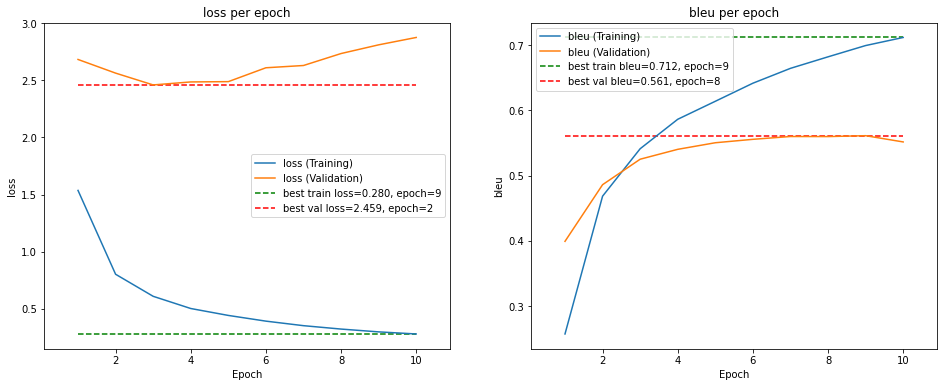

In [ ]:
plot_train_val_curves('logs/nmt-lstm-experiment/main/metrics.csv', ['loss', 'bleu'])

# Evaluate on Test Split

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/nmt-lstm-experiment/main/checkpoints/nmt-epoch=08-val_bleu=0.56.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at logs/nmt-lstm-experiment/main/checkpoints/nmt-epoch=08-val_bleu=0.56.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1          0.7171391844749451
       test_bleu_2          0.5925162434577942
       test_bleu_3          0.49949198961257935
       test_bleu_4          0.42319539189338684
        test_loss            2.817612648010254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.817612648010254,
  'test_bleu_1': 0.7171391844749451,
  'test_bleu_2': 0.5925162434577942,
  'test_bleu_3': 0.49949198961257935,
  'test_bleu_4': 0.42319539189338684}]

# Inspect test set prediction examples

In [ ]:
def process_test_predictions():
  bleu_score_1 = BLEUScore(n_gram=1)
  bleu_score_2 = BLEUScore(n_gram=2)
  bleu_score_3 = BLEUScore(n_gram=3)
  bleu_score_4 = BLEUScore(n_gram=4)
  n = len(model.test_gt_sentences)
  output = []
  for i in range(n):
    src = corpus_dataset.src_ids2string(corpus_dataset[model.test_idxs[i]]['src'])
    dst_gt = corpus_dataset.dst_ids2string(corpus_dataset[model.test_idxs[i]]['dst'])
    assert dst_gt == model.test_gt_sentences[i][0]
    dst_gen = model.test_gen_sentences[i]
    output.append({
        'src': src,
        'dst_gt': dst_gt,
        'dst_gen': dst_gen,
        'bleu_1': bleu_score_1([dst_gen], [[dst_gt]]).item(),
        'bleu_2': bleu_score_2([dst_gen], [[dst_gt]]).item(),
        'bleu_3': bleu_score_3([dst_gen], [[dst_gt]]).item(),
        'bleu_4': bleu_score_4([dst_gen], [[dst_gt]]).item(),
    })
  output.sort(key=lambda x : x['bleu_1']+x['bleu_2']+x['bleu_3']+x['bleu_4'], reverse=True)
  return output

In [ ]:
test_predictions = process_test_predictions()

**Top 8 examples**

In [ ]:
for i in range(8):
  pprint(test_predictions[i])
  print()

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'he estado esperando tres años .',
 'dst_gt': 'he estado esperando tres años .',
 'src': "i ' ve been waiting for three years ."}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'no me gusta hablar de fútbol .',
 'dst_gt': 'no me gusta hablar de fútbol .',
 'src': "i don ' t like talking about football ."}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'ha sido un buen día .',
 'dst_gt': 'ha sido un buen día .',
 'src': "it ' s been a good day ."}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'tom está en contra de fumar .',
 'dst_gt': 'tom está en contra de fumar .',
 'src': 'tom is against smoking .'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': '¿ entendiste todo ?',
 'dst_gt': '¿ entendiste todo ?',
 'src': 'did you understand everything ?'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.

**Worst 8 examples**

In [ ]:
for i in range(1, 9):
  pprint(test_predictions[-i])
  print()

{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'nos vemos a ustedes más tarde .',
 'dst_gt': '¡ hasta luego , <UNK> !',
 'src': 'see you guys later .'}

{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'nos vemos a ustedes más tarde .',
 'dst_gt': '¡ hasta luego , gente !',
 'src': 'see you guys later .'}

{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'comencemos .',
 'dst_gt': '¡ empecemos !',
 'src': "let ' s begin ."}

{'bleu_1': 0.09196986258029938,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'perdí el apetito .',
 'dst_gt': 'se me fueron las ganas de comer .',
 'src': "i ' ve lost my appetite ."}

{'bleu_1': 0.09942658245563507,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'guau , eso tiene pinta de buena pinta .',
 'dst_gt': '¡ <UNK> !, ¡ qué sabroso se ve eso !',
 'src': 'wow , that looks tasty .'}

{'bleu_1': 0.09999999403953552,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 

**10 random examples**

In [ ]:
for i in random.sample(range(20, len(test_predictions) - 20), 10):
  pprint(test_predictions[i])
  print()

{'bleu_1': 0.6618726849555969,
 'bleu_2': 0.5003286600112915,
 'bleu_3': 0.3326781094074249,
 'bleu_4': 0.0,
 'dst_gen': 'los peces no sobreviven fuera de agua .',
 'dst_gt': 'los peces no pueden vivir fuera del agua .',
 'src': 'fish cannot live out of water .'}

{'bleu_1': 0.5515605807304382,
 'bleu_2': 0.37292301654815674,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': '¿ puede decirme el camino al banco ?',
 'dst_gt': '¿ me enseñas el camino hacia el banco ?',
 'src': 'can you tell me the way to the bank ?'}

{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'dst_gen': 'le dije a tom lo que sé .',
 'dst_gt': 'le dije a tom lo que sé .',
 'src': 'i told tom what i know .'}

{'bleu_1': 0.5454545617103577,
 'bleu_2': 0.3302891254425049,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'dst_gen': 'la <UNK> del camión estaba en <UNK> de tres yenes .',
 'dst_gt': 'la carga del camión fue de más de tres toneladas .',
 'src': 'the load of the truck was in <UNK> of three tons .'}

{'bleu_1': 0.

# References
- D. Bahdanau, K. Cho, and Y. Bengio. Neural machine translation by jointly learning to align and translate. In ICLR, 2015. (https://arxiv.org/abs/1409.0473)
- I. Sutskever, O. Vinyals, and Q. Le. Sequence to sequence learning with neural networks. In NeurIPS, 2014. (https://arxiv.org/abs/1409.3215)